# Revolving Door

#### Goal:
- You belong to the people analytics team for a food conglomerate. Employee turnover
has been rampant for your 10 subsidiaries. 
- The CFO estimates that the cost of
replacing an employee is often larger than 100K USD, taking into account the time
spent to interview and find a replacement, placement fees, sign-on bonuses and the
loss of productivity for several months.
- Your team has been tasked with diagnosing why and when employees from your
subsidiaries leave. You need a tangible data-driven recommendation for each of the ten
Presidents of your subsidiaries. What are your recommendations and why?

#### Challenge Description
We got employee data from a few companies. We have data about all employees who
joined from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still
at the company as of 2015/12/13 or they have quit. Beside that, we have general info
about the employee, such as average salary during her tenure, department, and years
of experience. As said above, the goal is to predict employee retention and understand
its main drivers

#### Data
- "employee_retention" - comprehensive information about employees. Columns:
- employee_id : id of the employee. Unique by employee per company
- company_id : company id.
- dept : employee department
- seniority : number of yrs of work experience when hired
- salary: average yearly salary of the employee during her tenure within the company
- join_date: when the employee joined the company, it can only be between

#### Obvious questions
- Is it money?
- Is it department?
- Is it years of experience?
- Is it company?
- Is it seniority
- Is it cohort-related?

#### Actionable features
- Hires over time
    - Is there a cohort effect
    - Are there cycles
    - Average time before leaving
        - Per department
        - per company
        - per seniority
        - per salary
        - per join date
    - Are people being hired for less over time?
    - Are people retiring?
- Normalize to total population vs subsidiary population
- Departmental population

#### Assumptions
- Disregard salary
- No quit date means they're still there
- Tenure calculated as quit date as the last date in the dataset
- Removed join dates before 2008, which had temp workers

## Recommendations
- There are two waves, one ~1 year and a smaller around 2 years, where people leave
        
        
- **Companies 1 and 2** have more senior highs and better salary/tenure ratio
    - Need average seniority over time
        - Are they not being promoted?
        - Is the average salary due to the starting salary and they aren't getting raises?
        - Are they so senior that they are retiring?
        - **Possible retention strategies:**
            - Better promotions/raises
            - Hire younger or with less seniority
            
            
- **Company 11** has the highest number of long-tenured employees despite low salary
    - There may be something in the culture here that promotes long tenures
    - Look more closely into the operations of this company to help improve the others
    
    
- **Company 12** has the lowest tenure, lowest seniority, and lowest pay, basically run by temps
    - Use this one as a model for what not to do
    - Definitely, need to increase pay for this one, and more senior hires 
    

- **Companies 1-10** have current employees that have not reached the average length of tenure of the quitters, so they are likely to be quitting if changes aren't made



## Data Loading and Prep

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from datetime import datetime as dt

%matplotlib inline 
%config InlineBackend.figure_format = "retina"
sns.set_style ("whitegrid")
plt.style.use("seaborn-muted")

#### Group Scatter Function

In [2]:
def group_scatter(tmp, x_col, y_col, ylim = None, xlim = None):
    fig, ax = plt.subplots(figsize = (20,5))
    a = ax.plot(tmp[x_col][tmp.status == 0], 
                tmp[y_col][tmp.status == 0], 
                color = 'darkcyan', label = 'Current', ls = 'None', 
                alpha = 0.5, marker = 'o', ms = 10)
    a = ax.plot(tmp[x_col][tmp.status == 1], 
                tmp[y_col][tmp.status == 1], 
                color = 'rebeccapurple', label = 'Quit', ls = 'None', 
                alpha = 0.5, marker = 'o', ms = 10)
    ax.set_xlabel(x_col, fontsize = 18)
    ax.set_ylabel(y_col, fontsize = 18)
    ax.tick_params (labelsize = 15)
    ax.axhline(np.mean(tmp[y_col][tmp.status == 0]), color = 'k', label = "Current Mean")
    ax.axhline(np.mean(tmp[y_col][tmp.status == 1]), color = 'k', ls = ":", label = "Quit Mean")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend (handles, labels, bbox_to_anchor = (1.15,1), fontsize = 15)
    if ylim != None:
        ax.set_ylim(ylim)
    if xlim != None:
        ax.set_xlim(xlim)
    return ax

#### Group Bar Graph Function

In [3]:
def group_bar(x_col, y_col, ylim = None, xlim = None):
    fig, ax = plt.subplots(figsize = (20,5))
    a = ax.bar(df[x_col][df.status == 0], 
                df[y_col][df.status == 0], 
                color = 'darkcyan', label = 'Current', ls = 'None', 
                alpha = 0.1)
    a = ax.bar(df[x_col][df.status == 1], 
                df[y_col][df.status == 1], 
                color = 'rebeccapurple', label = 'Quit', ls = 'None', 
                alpha = 0.1)
    ax.set_xlabel(x_col, fontsize = 18)
    ax.set_ylabel(y_col, fontsize = 18)
    ax.tick_params (labelsize = 15)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend (handles, labels, bbox_to_anchor = (1.15,1), fontsize = 15)
    if ylim != None:
        ax.set_ylim(ylim)
    if xlim != None:
        ax.set_xlim(xlim)
    return ax

#### Function to plot a histogram panel

In [4]:
def visualize_hist (tmp):
    """Plot a custom histogram panel of all features. 
    Input is a dataframe. Returns the figure. """
    
    panels = len(tmp.columns.values)
    cols = 3
    rows = round(panels//cols) 
    if panels % (cols) != 0:
        rows += 1
    fig, ax = plt.subplots(rows, cols, figsize = (rows*4,rows*3))
    i = 0
    j = 0
    for c in tmp.columns.values:
        ax[i][j].hist(tmp[c], label = c, edgecolor = 'dimgray')
        ax[i][j].set_title ('\n' + c + '\n', fontsize = 18)
        ax[i][j].tick_params (labelsize = 14)
        if j == cols-1:
            j = -1
            i += 1
        j += 1
    print ('waiting on plot...')
    plt.tight_layout()
    plt.show()
    return fig

#### Function to plot correlation matrix

In [5]:
def plot_corr(tmp, cmap = 'Blues'):
    """Plot dataframe's correlation heatmap with annotations. 
    Input is a dataframe. Returns the figure."""
    
    fig, ax = plt.subplots(figsize = (14,12))
    sns.heatmap(tmp.corr(), cmap = cmap, annot = True)
    plt.tight_layout()
    plt.show()
    return fig

#### Function to plot a bar graph panel

In [6]:
def visualize_bar(tmp, x):
    """Plot a custom panel of vertical bar plots 
    for all features in a dataset. Input is a 
    dataframe and a column for the x axis. 
    Returns the figure."""
    
    panels = len(tmp.columns.values)
    cols = 3
    rows = round(panels//cols) 
    if panels % (cols) != 0:
        rows += 1
    fig, ax = plt.subplots(rows, cols, 
              figsize = (rows*4,rows*4))
    i = 0
    j = 0
    for c in tmp.columns.values:
        ax[i][j].bar(tmp[x], tmp[c])
        ax[i][j].set_title ('\n' + c + '\n', fontsize = 18)
        ax[i][j].tick_params (labelsize = 16)
        ax[i][j].set_xlabel (x, fontsize = 18)
        ax[i][j].set_ylabel (c, fontsize = 18)
        if j == cols-1:
            j = -1
            i += 1
        j += 1
    print ('waiting on plot')
    plt.tight_layout()
    plt.show()
    return fig

#### Function to visualize ranked segmentation

In [7]:
def visualize_segments (tmp,x, exclude):
    """Takes a dataframe grouped by cluster number (or segment number)
    and plots it vs mean rank, score or value of a feature column"""
    fig, ax = plt.subplots (1,1, figsize = (8,5))
    markers = ['s', 'o', 'v', '^','*', 'X', 'p','D','<', '>', 's', 'o']
    for i, c in enumerate(dfg.columns.values):
        if c != x and c not in exclude:
            ax.scatter (tmp[x], tmp[c], s = 120, ec = 'k', alpha = 0.5, 
                        label = c, cmap = 'rainbow', marker = markers[i])
    ax.set_xlabel('Status', fontsize = 16)
    ax.set_ylabel('Mean Score', fontsize = 16)
    ax.tick_params(labelsize = 14)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize = 14, bbox_to_anchor = (1,1))
    fig = ax.set_title('Employment Status\n', fontsize = 20)
    plt.show()
    return fig

#### Read in Data

In [8]:
df_orig = pd.read_csv(os.path.join('data', 'employee_retention.txt'))
df_orig

,Unnamed: 0,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,0,1001444.0,8,temp_contractor,0,5850.0,2008-01-26,2008-04-25
1,1,388804.0,8,design,21,191000.0,05.17.2011,2012-03-16
2,2,407990.0,3,design,9,90000.0,2012-03-26,2015-04-10
3,3,120657.0,2,engineer,20,298000.0,2013-04-08,2015-01-30
4,4,1006393.0,1,temp_contractor,0,8509.0,2008-07-20,2008-10-18
...,...,...,...,...,...,...,...,...
34697,34697,998574.0,5,marketing,6,106000.0,2013-09-23,2015-07-31
34698,34698,90987.0,3,customer_service,2,24000.0,2011-06-06,2013-07-11
34699,34699,1009820.0,2,temp_contractor,0,7176.0,2009-01-18,2009-04-18
34700,34700,1002557.0,1,temp_contractor,0,9297.0,2008-11-27,2009-02-25


In [9]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34702 entries, 0 to 34701
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   34702 non-null  int64  
 1   employee_id  34702 non-null  float64
 2   company_id   34702 non-null  int64  
 3   dept         34702 non-null  object 
 4   seniority    34702 non-null  int64  
 5   salary       34463 non-null  float64
 6   join_date    34702 non-null  object 
 7   quit_date    23510 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 2.1+ MB


In [10]:
df_orig.isna().sum()

Unnamed: 0         0
employee_id        0
company_id         0
dept               0
seniority          0
salary           239
join_date          0
quit_date      11192
dtype: int64

In [11]:
df_orig

,Unnamed: 0,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,0,1001444.0,8,temp_contractor,0,5850.0,2008-01-26,2008-04-25
1,1,388804.0,8,design,21,191000.0,05.17.2011,2012-03-16
2,2,407990.0,3,design,9,90000.0,2012-03-26,2015-04-10
3,3,120657.0,2,engineer,20,298000.0,2013-04-08,2015-01-30
4,4,1006393.0,1,temp_contractor,0,8509.0,2008-07-20,2008-10-18
...,...,...,...,...,...,...,...,...
34697,34697,998574.0,5,marketing,6,106000.0,2013-09-23,2015-07-31
34698,34698,90987.0,3,customer_service,2,24000.0,2011-06-06,2013-07-11
34699,34699,1009820.0,2,temp_contractor,0,7176.0,2009-01-18,2009-04-18
34700,34700,1002557.0,1,temp_contractor,0,9297.0,2008-11-27,2009-02-25


#### Make a working copy of the original data

In [12]:
df = df_orig.copy()

In [13]:
drops = [c for c in df.columns.values if 'unnamed' in c.lower()]
df = df.drop(drops, axis = 1)
df = df[df.salary.isna() == False]

#### Remove Data < 2011 (Temp workers)

In [14]:
df2 = df[df.join_date < '2011-01-24']
df = df[df.join_date >= '2011-01-24']

#### Missing data per column

In [15]:
df.isna().sum()

employee_id       0
company_id        0
dept              0
seniority         0
salary            0
join_date         0
quit_date      7753
dtype: int64

#### Descriptive statistics

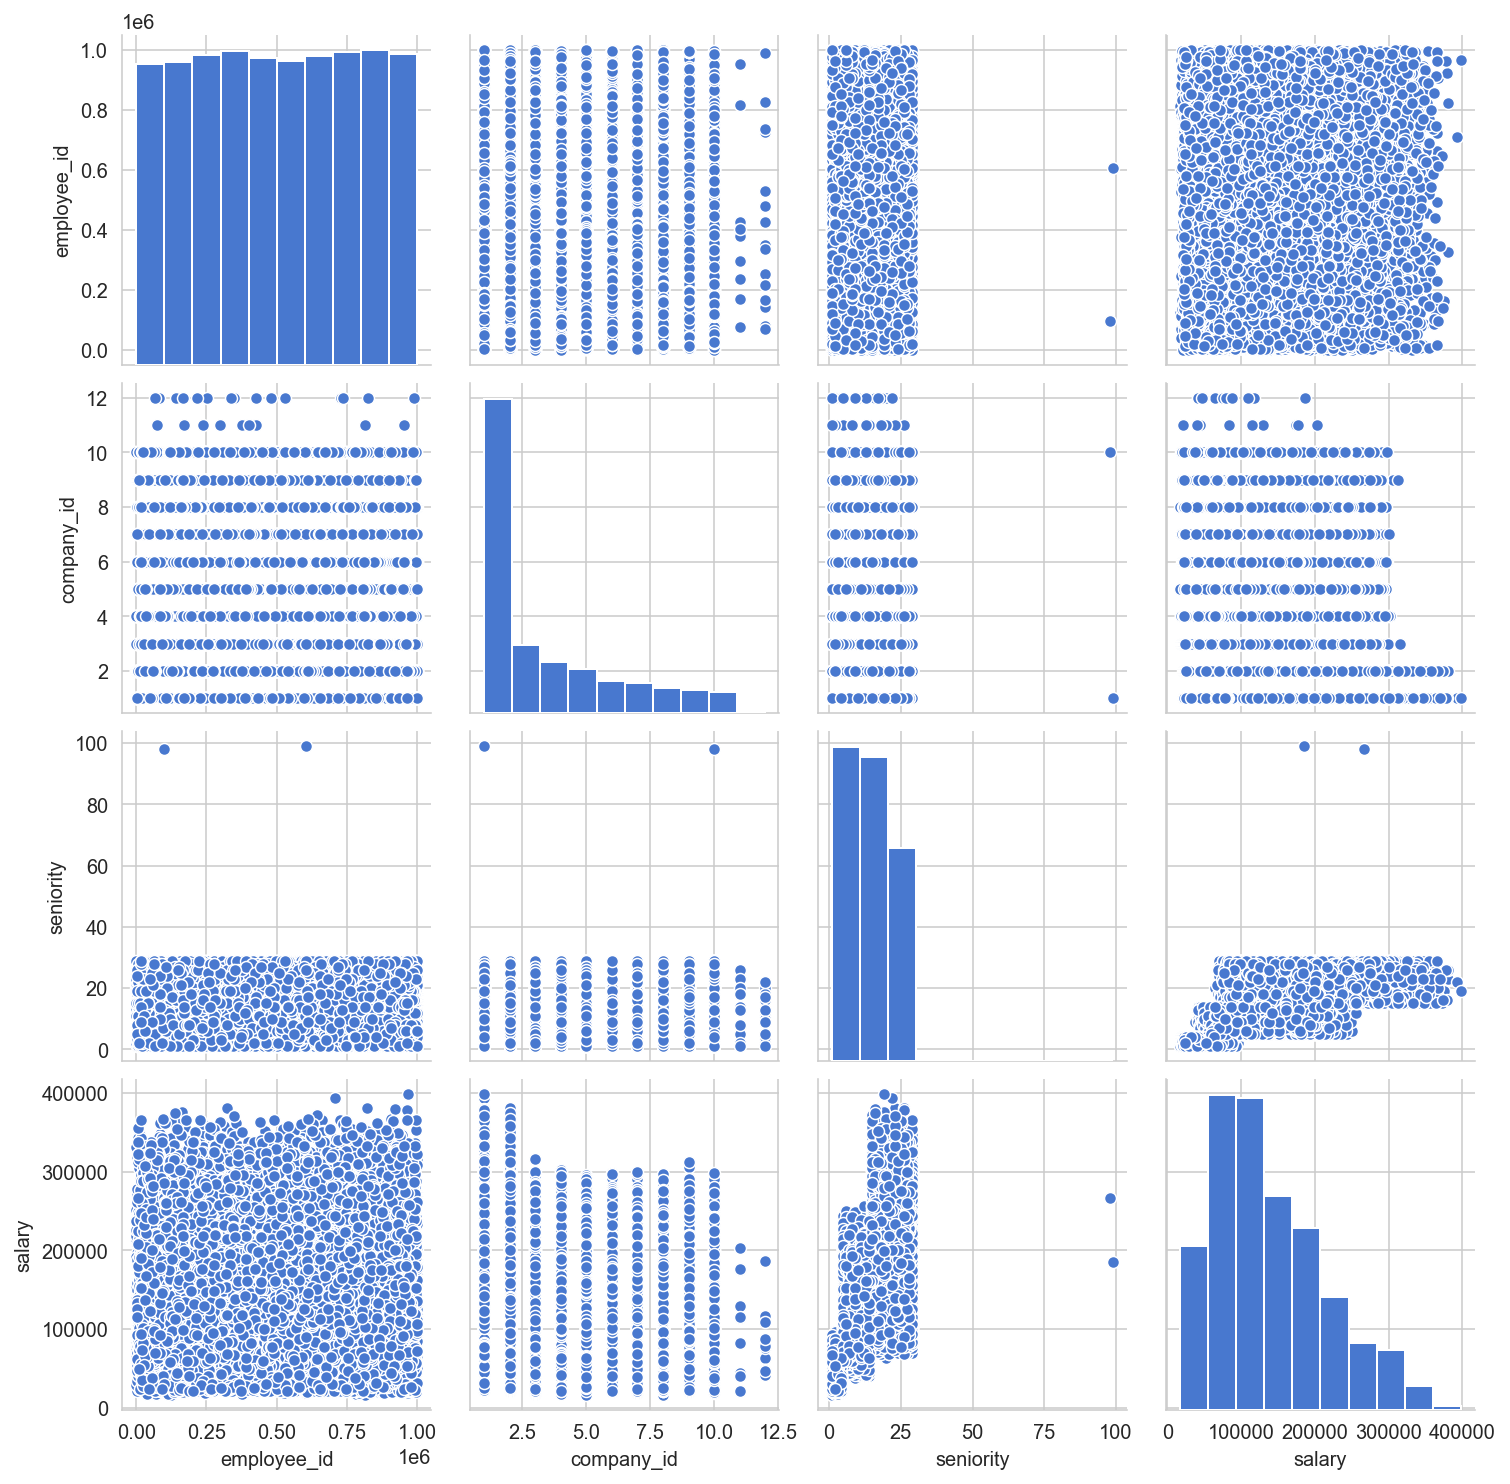

In [16]:
sns.pairplot(df)

## Feature Engineering

- How long do they stay
- Is hiring date related to tenure?
- What is the average salary/hire?
- What is the average senority/hire
- What is the average salary/seniority?
- Is the rate of hiring and firing changing over time?
- Is length of tenure changing over time?
- What makes a lifer from a transient?
- Is tenure related to the position/department?

#### Status

In [17]:
df['status'] = ''
df.status = np.where(df.quit_date.isna() == True, 0, df.status) # Current = 0
df.status = np.where(df.quit_date.isna() == False, 1, df.status)  # Quit = 1

#### Convert Quit_Date NaN to last day in dataset

In [18]:
df.quit_date = np.where(df.quit_date.isna() == True, '2015-12-13', df.quit_date)

#### Convert dates to datetime

In [19]:
# Have some different date formats in the same column
np.unique(df.join_date)[:5]

array(['2011-01-24', '2011-01-25', '2011-01-26', '2011-01-31',
       '2011-02-01'], dtype=object)

In [20]:
# Splits dates separated with '.' and rejoins them with '-' in the right order
df.join_date = [(d.split('.')[2] + '-' + d.split('.')[0] + '-' + d.split('.')[1]) \
                if '.' in d else d for d in df.join_date]
df.join_date = pd.to_datetime(df.join_date, format = '%Y-%m-%d')

In [21]:
df['quit_date'] = pd.to_datetime(df.quit_date, 
               format = "%Y-%m-%d", errors = 'coerce')
               # NaN becomes NaT

In [22]:
# Checking dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17091 entries, 2 to 34701
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   employee_id  17091 non-null  float64       
 1   company_id   17091 non-null  int64         
 2   dept         17091 non-null  object        
 3   seniority    17091 non-null  int64         
 4   salary       17091 non-null  float64       
 5   join_date    17091 non-null  datetime64[ns]
 6   quit_date    17091 non-null  datetime64[ns]
 7   status       17091 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(2), object(2)
memory usage: 1.8+ MB


#### Tenure

In [23]:
df['tenure'] = df.quit_date - df.join_date
df.tenure = df.tenure.dt.days

#### Salary/Tenure Ratio

In [24]:
df['salary_to_tenure'] = df.salary/df.tenure

#### Salary/Seniority Ratio

In [25]:
df['salary_to_seniority'] = df.salary/df.seniority

#### Senority/Tenure Ratio

In [26]:
df['seniority_to_tenure'] = df.seniority/df.tenure

## Accounting Metrics

#### Hires vs Time

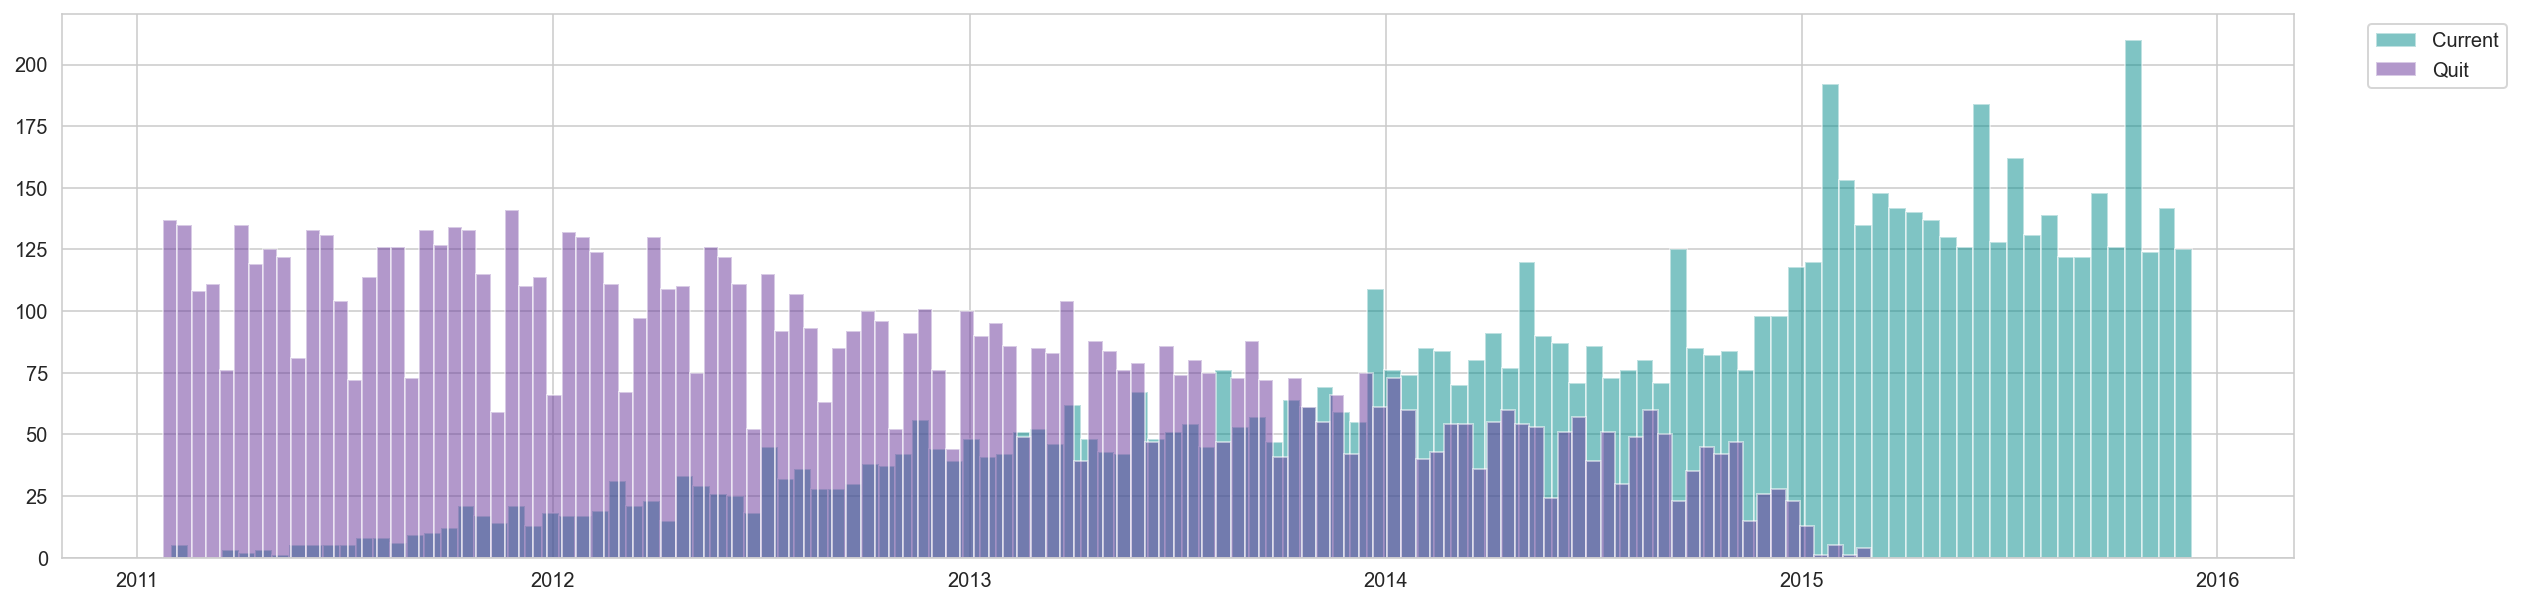

In [27]:
fig, ax = plt.subplots(figsize = (20,5))
a = ax.hist(df.join_date[df.status == 0], bins = 120, 
            alpha = 0.5, color = 'darkcyan', label = 'Current')
a = ax.hist(df.join_date[df.status == 1], 
            alpha = 0.5, bins = 120, color = 'rebeccapurple', label = 'Quit')
handles, labels = ax.get_legend_handles_labels()
ax.legend (handles, labels, bbox_to_anchor = (1.1,1))

- The more recent hires are the ones that have not yet quit
- Most of the ones that quit were hired before 2013
- Most of the ones currently employed were hired around the start of 2014
- There's a brief intersectionat the end of 2013 to mid 2014 where there was a changing of the guard.
     - change in managment?
     - retired?
     - Lack of raises?
     - Lack of promotion?

#### Tenure Histogram by Days

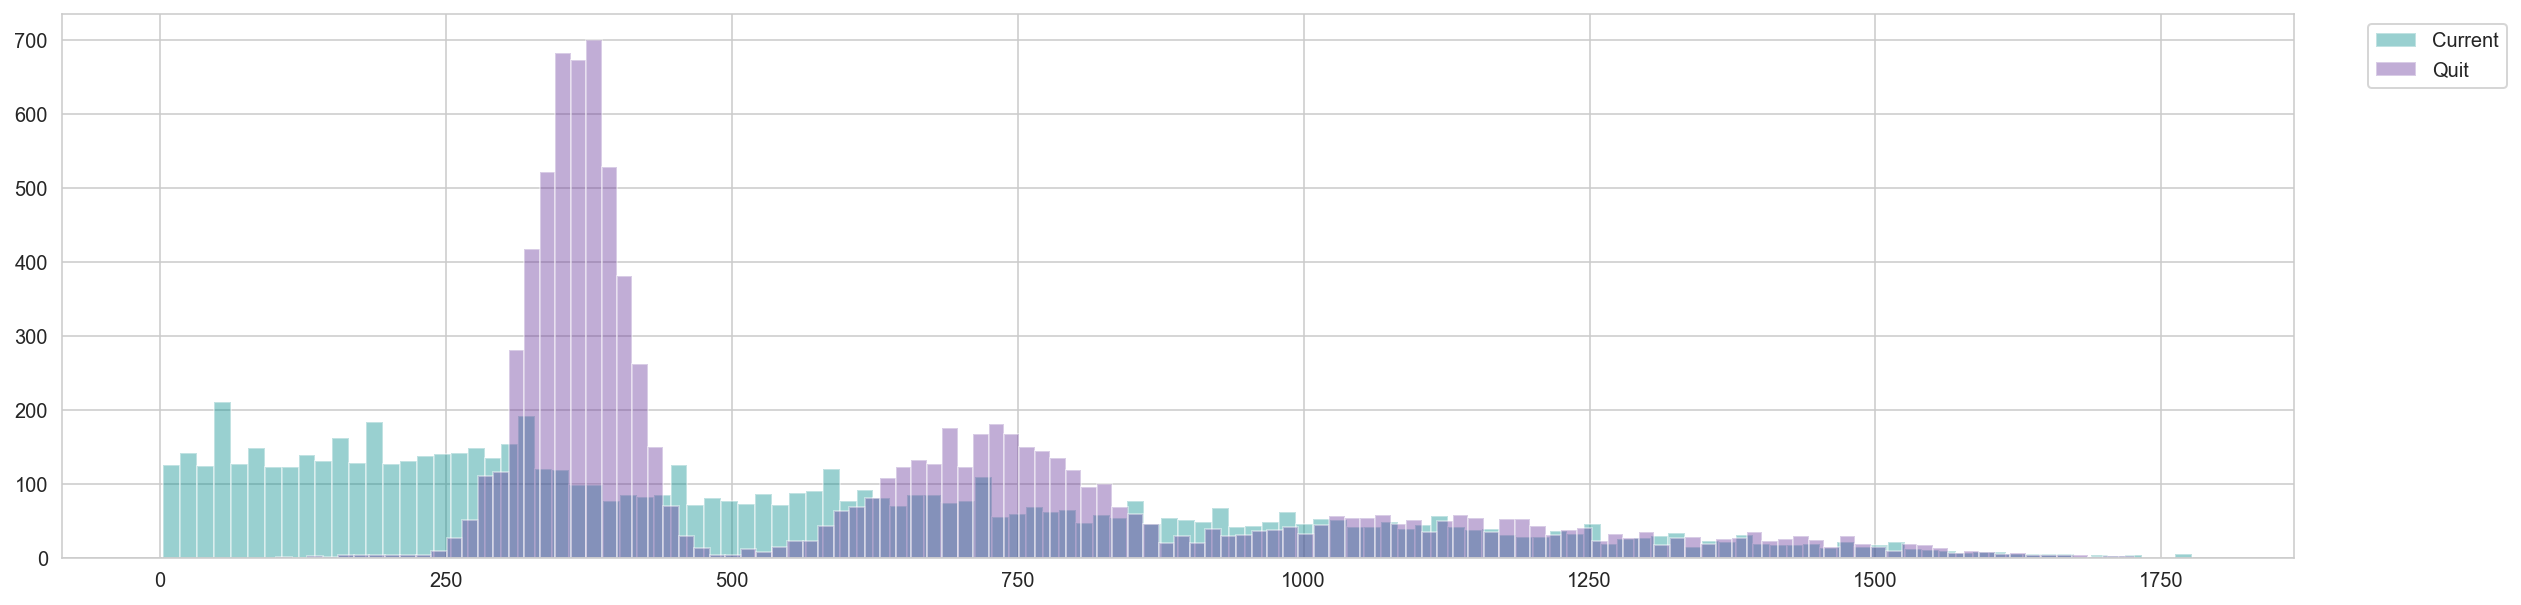

In [28]:
fig, ax = plt.subplots(figsize = (20,5))
a = ax.hist(df.tenure[df.status == 0], bins = 120, 
            color = 'darkcyan', alpha = 0.4, label = 'Current')
a = ax.hist(df.tenure[df.status == 1], bins = 120, 
            color = 'rebeccapurple', alpha = 0.4, label = 'Quit')
handles, labels = ax.get_legend_handles_labels()
ax.legend (handles, labels, bbox_to_anchor = (1.1,1))

- Those that quit did so primarily at the 1 year anniversary
- The second wave quit at the 2-year anniversary
- Less than half stay around more than a year, leaving within 90 days of their 1 year anniversary
    - Rules out retirement
    - Unless management is changing every year, not likely to be management
    - Most likely salary or promotions

## Actionable Metrics

In [29]:
exclude = ['employee_id', 'company_id', 'dept', 'seniority', 'salary', 'join_date', 'quit_date']

In [30]:
tmp = df.drop (exclude, axis = 1)

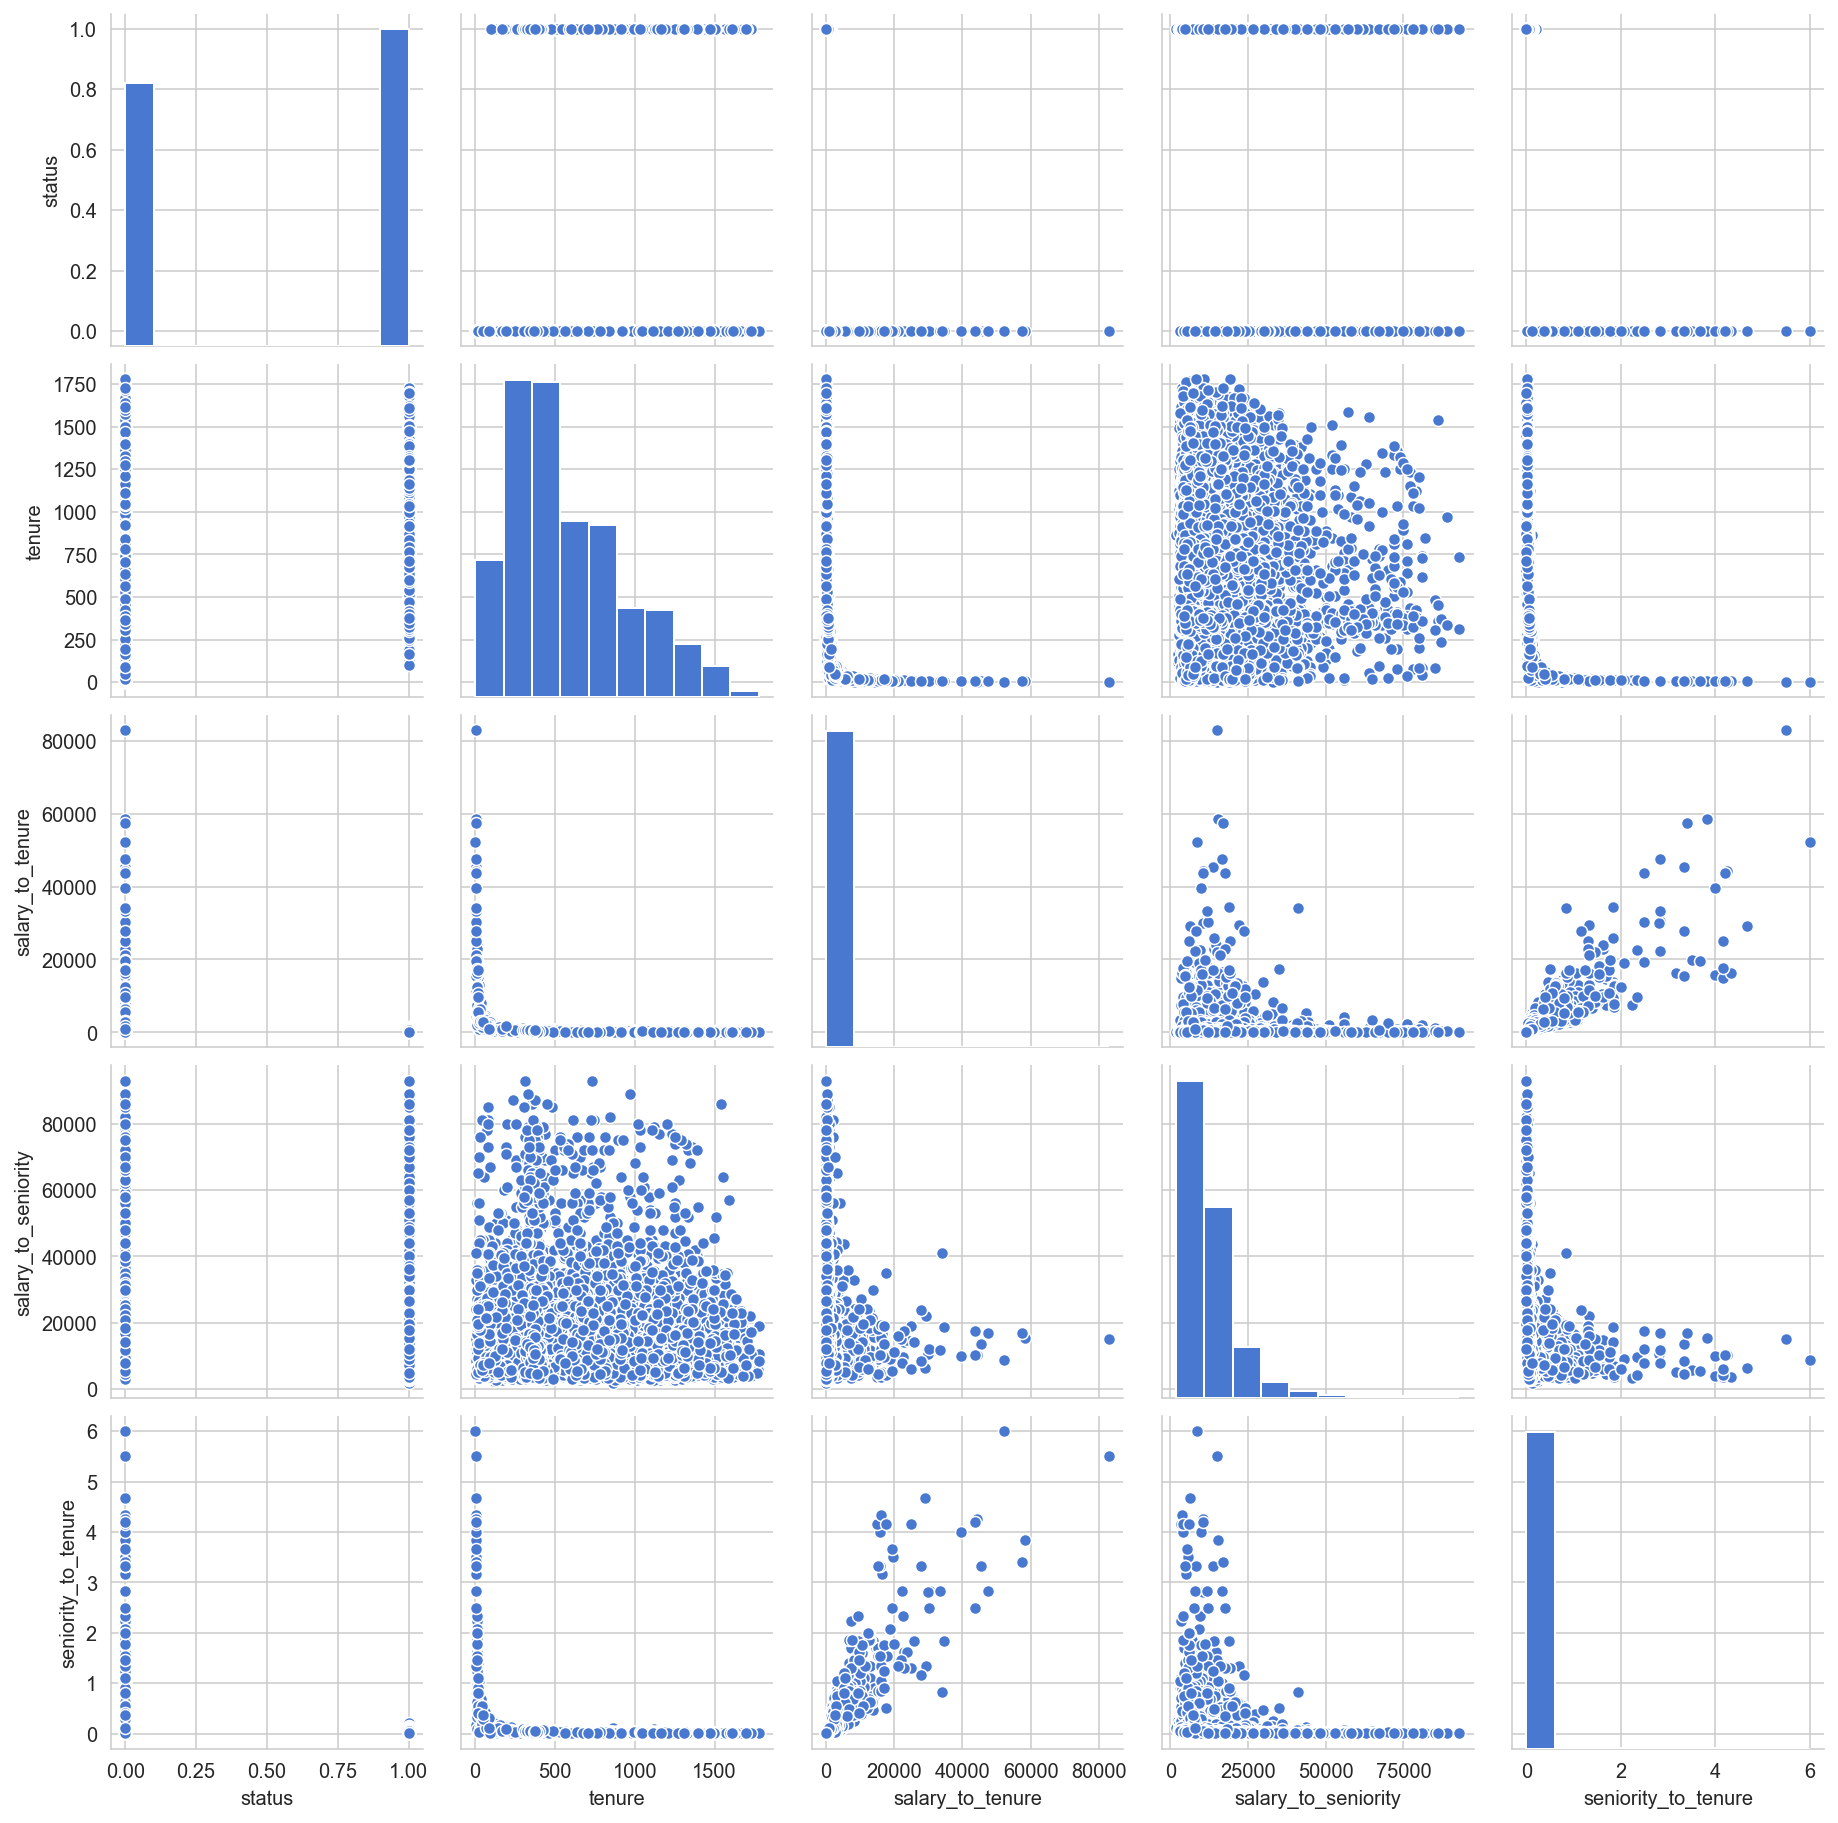

In [31]:
sns.pairplot(tmp)

- linear correlation of seniority to tenure and salary to tenure
- exponential relationship between seniority to tenure and salary to seniory
- mean is slightly right skewed with median around 365 days for tenure
- Salary grows with seniority


waiting on plot...


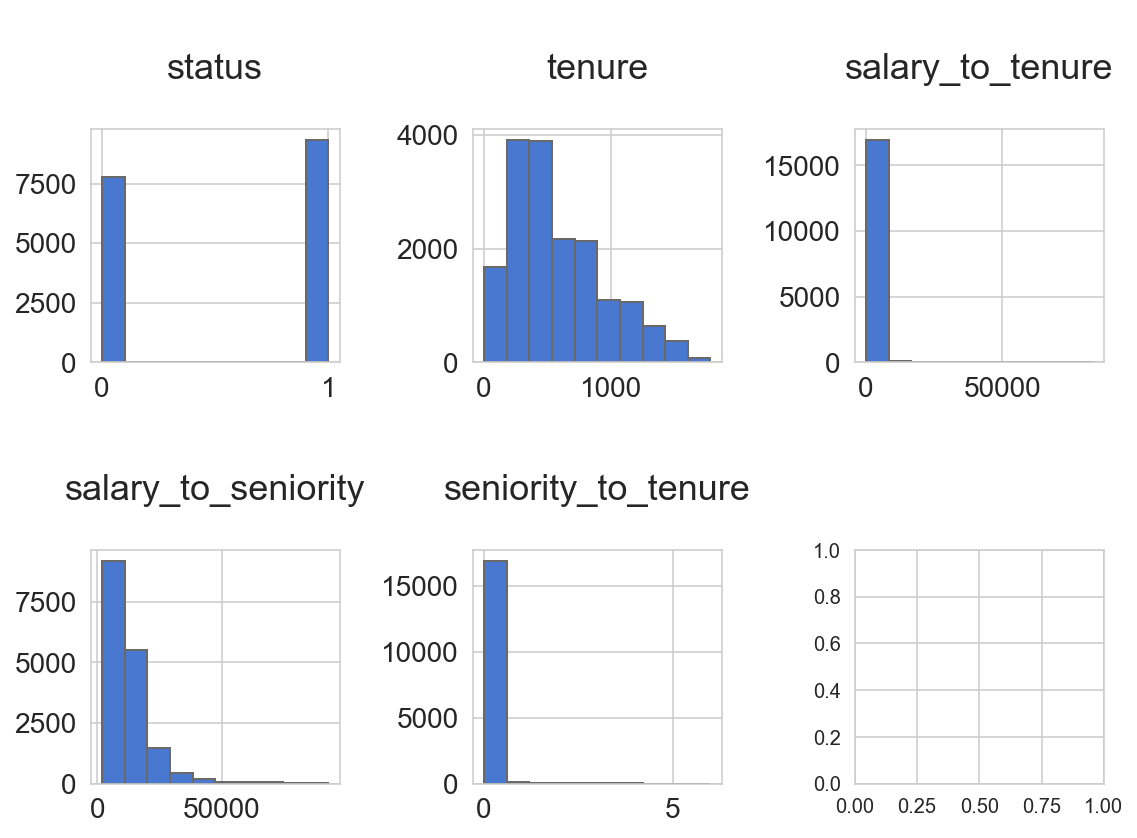

In [32]:
a = visualize_hist(tmp)

In [33]:
#visualize_bar(tmp, 'tenure')

## Check for Linear Relationships

In [34]:
linear_corr = df.corr(method = 'pearson')#[c]
sorted_corr = np.argsort(np.abs(linear_corr))#[c]

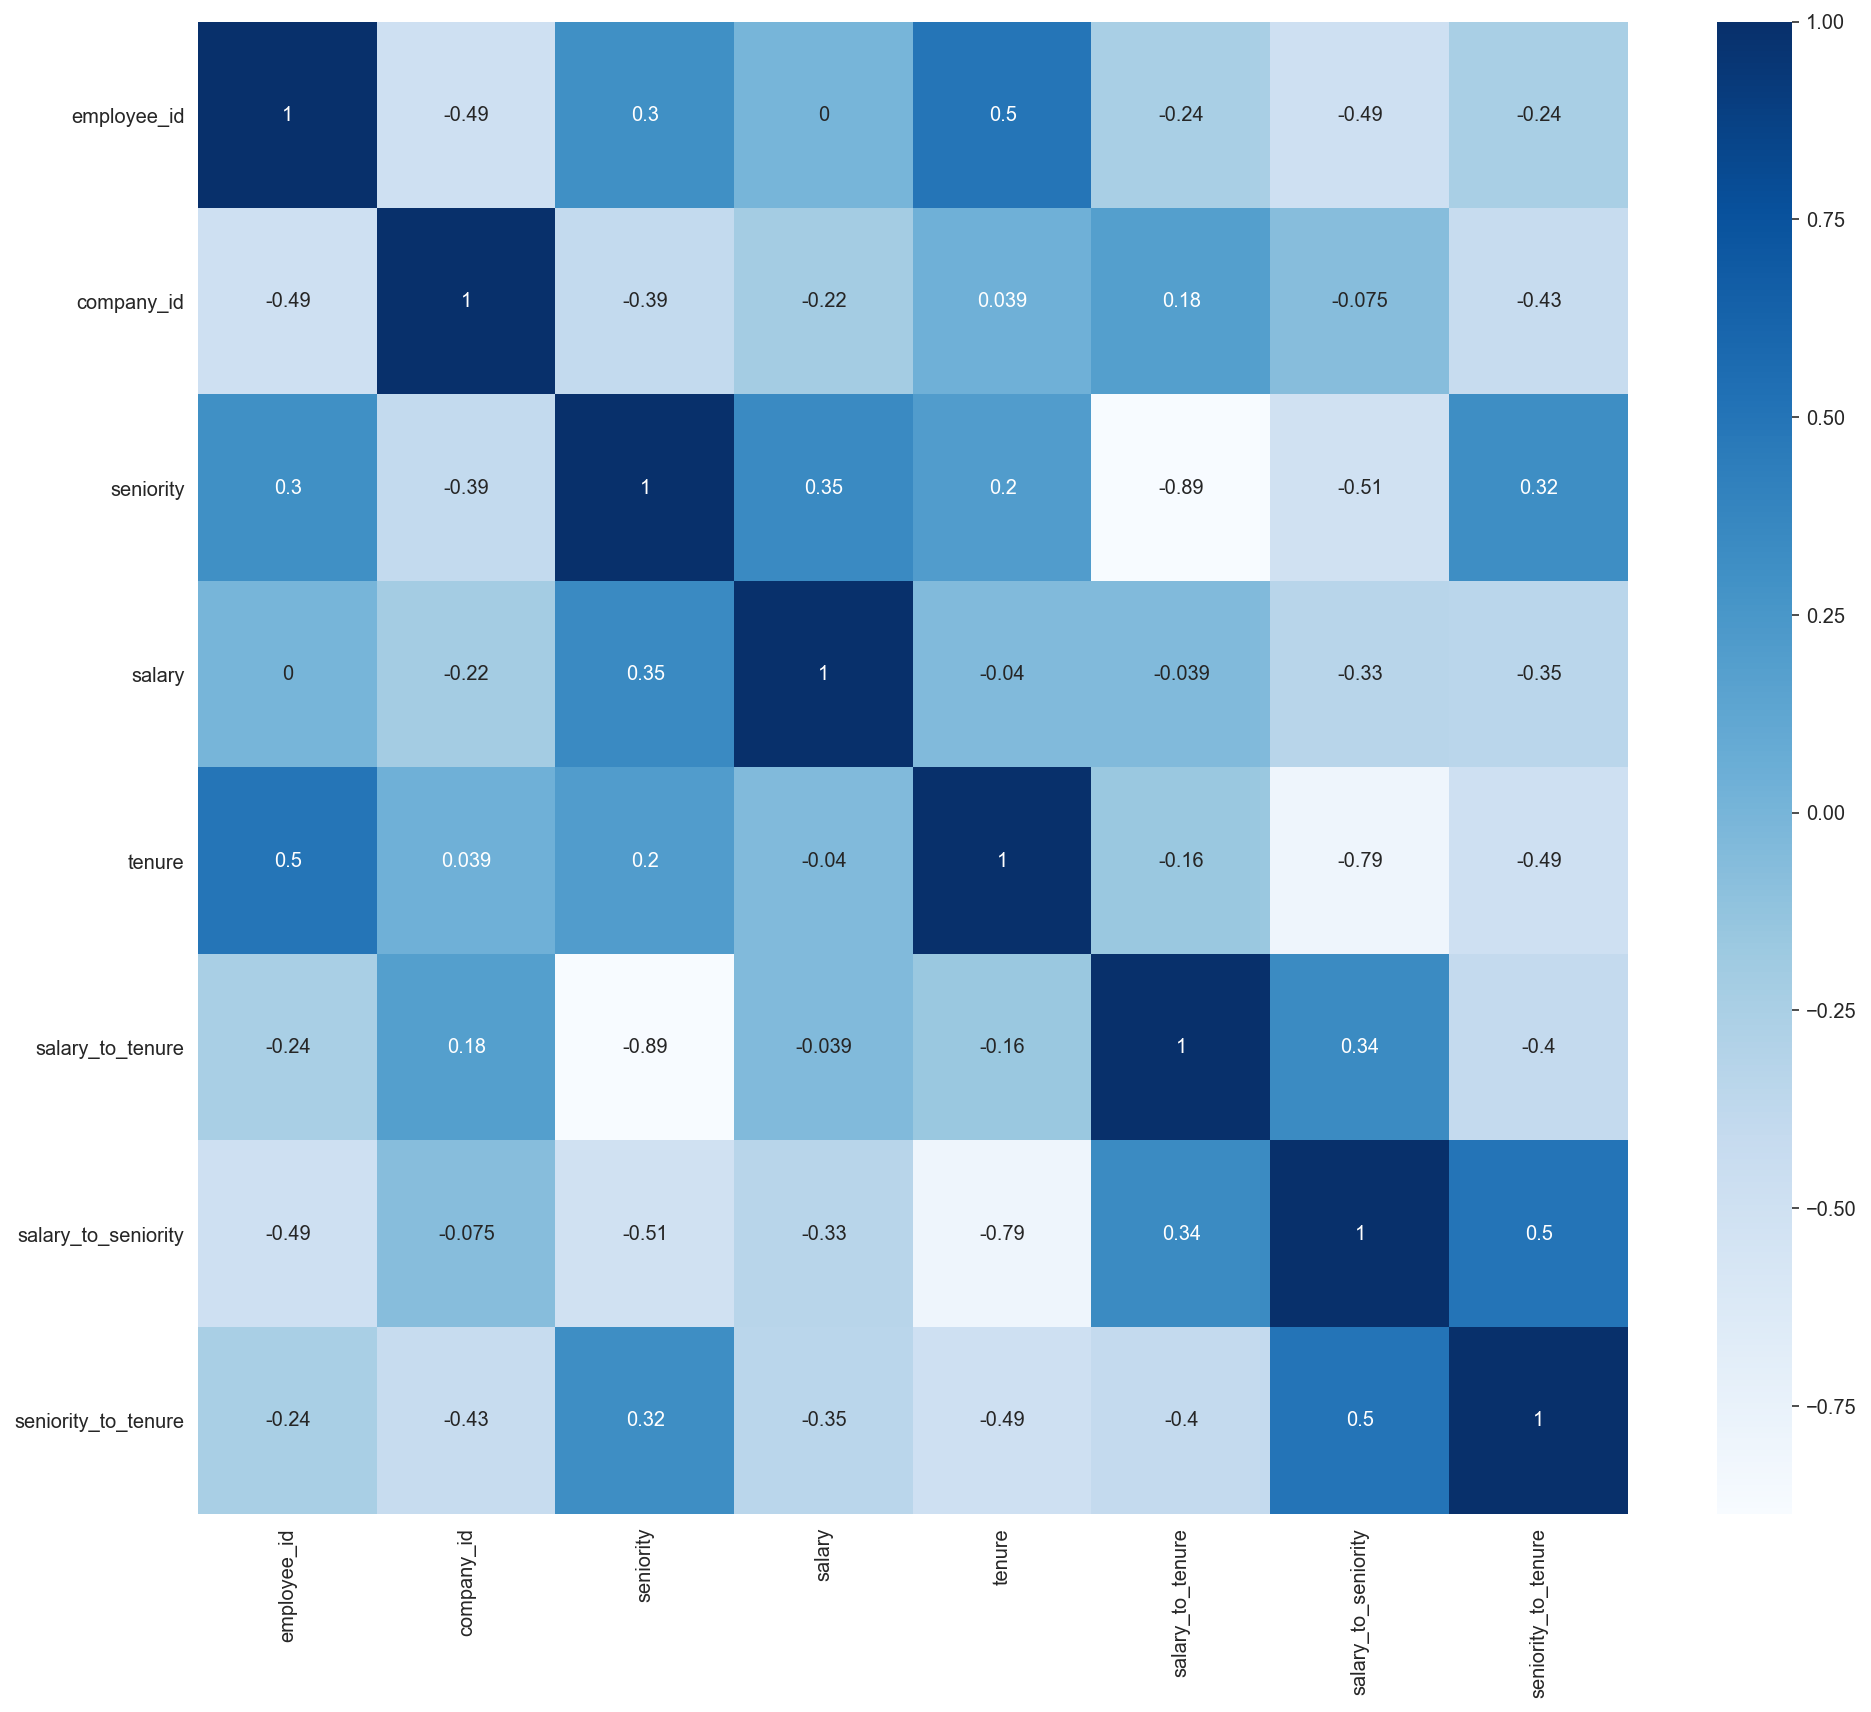

In [35]:
f = plot_corr(sorted_corr)

- Salary: Seniority and seniority to tenure are highly correlated
- Salary to tenure and salary to seniority are less correlated
- Salary and seniority are correlated-ish

## Check for Non-inear Relationships

In [36]:
nonlinear_corr = df.corr(method = 'spearman')#[c]
sorted_corr = np.argsort(np.abs(nonlinear_corr))#[c]

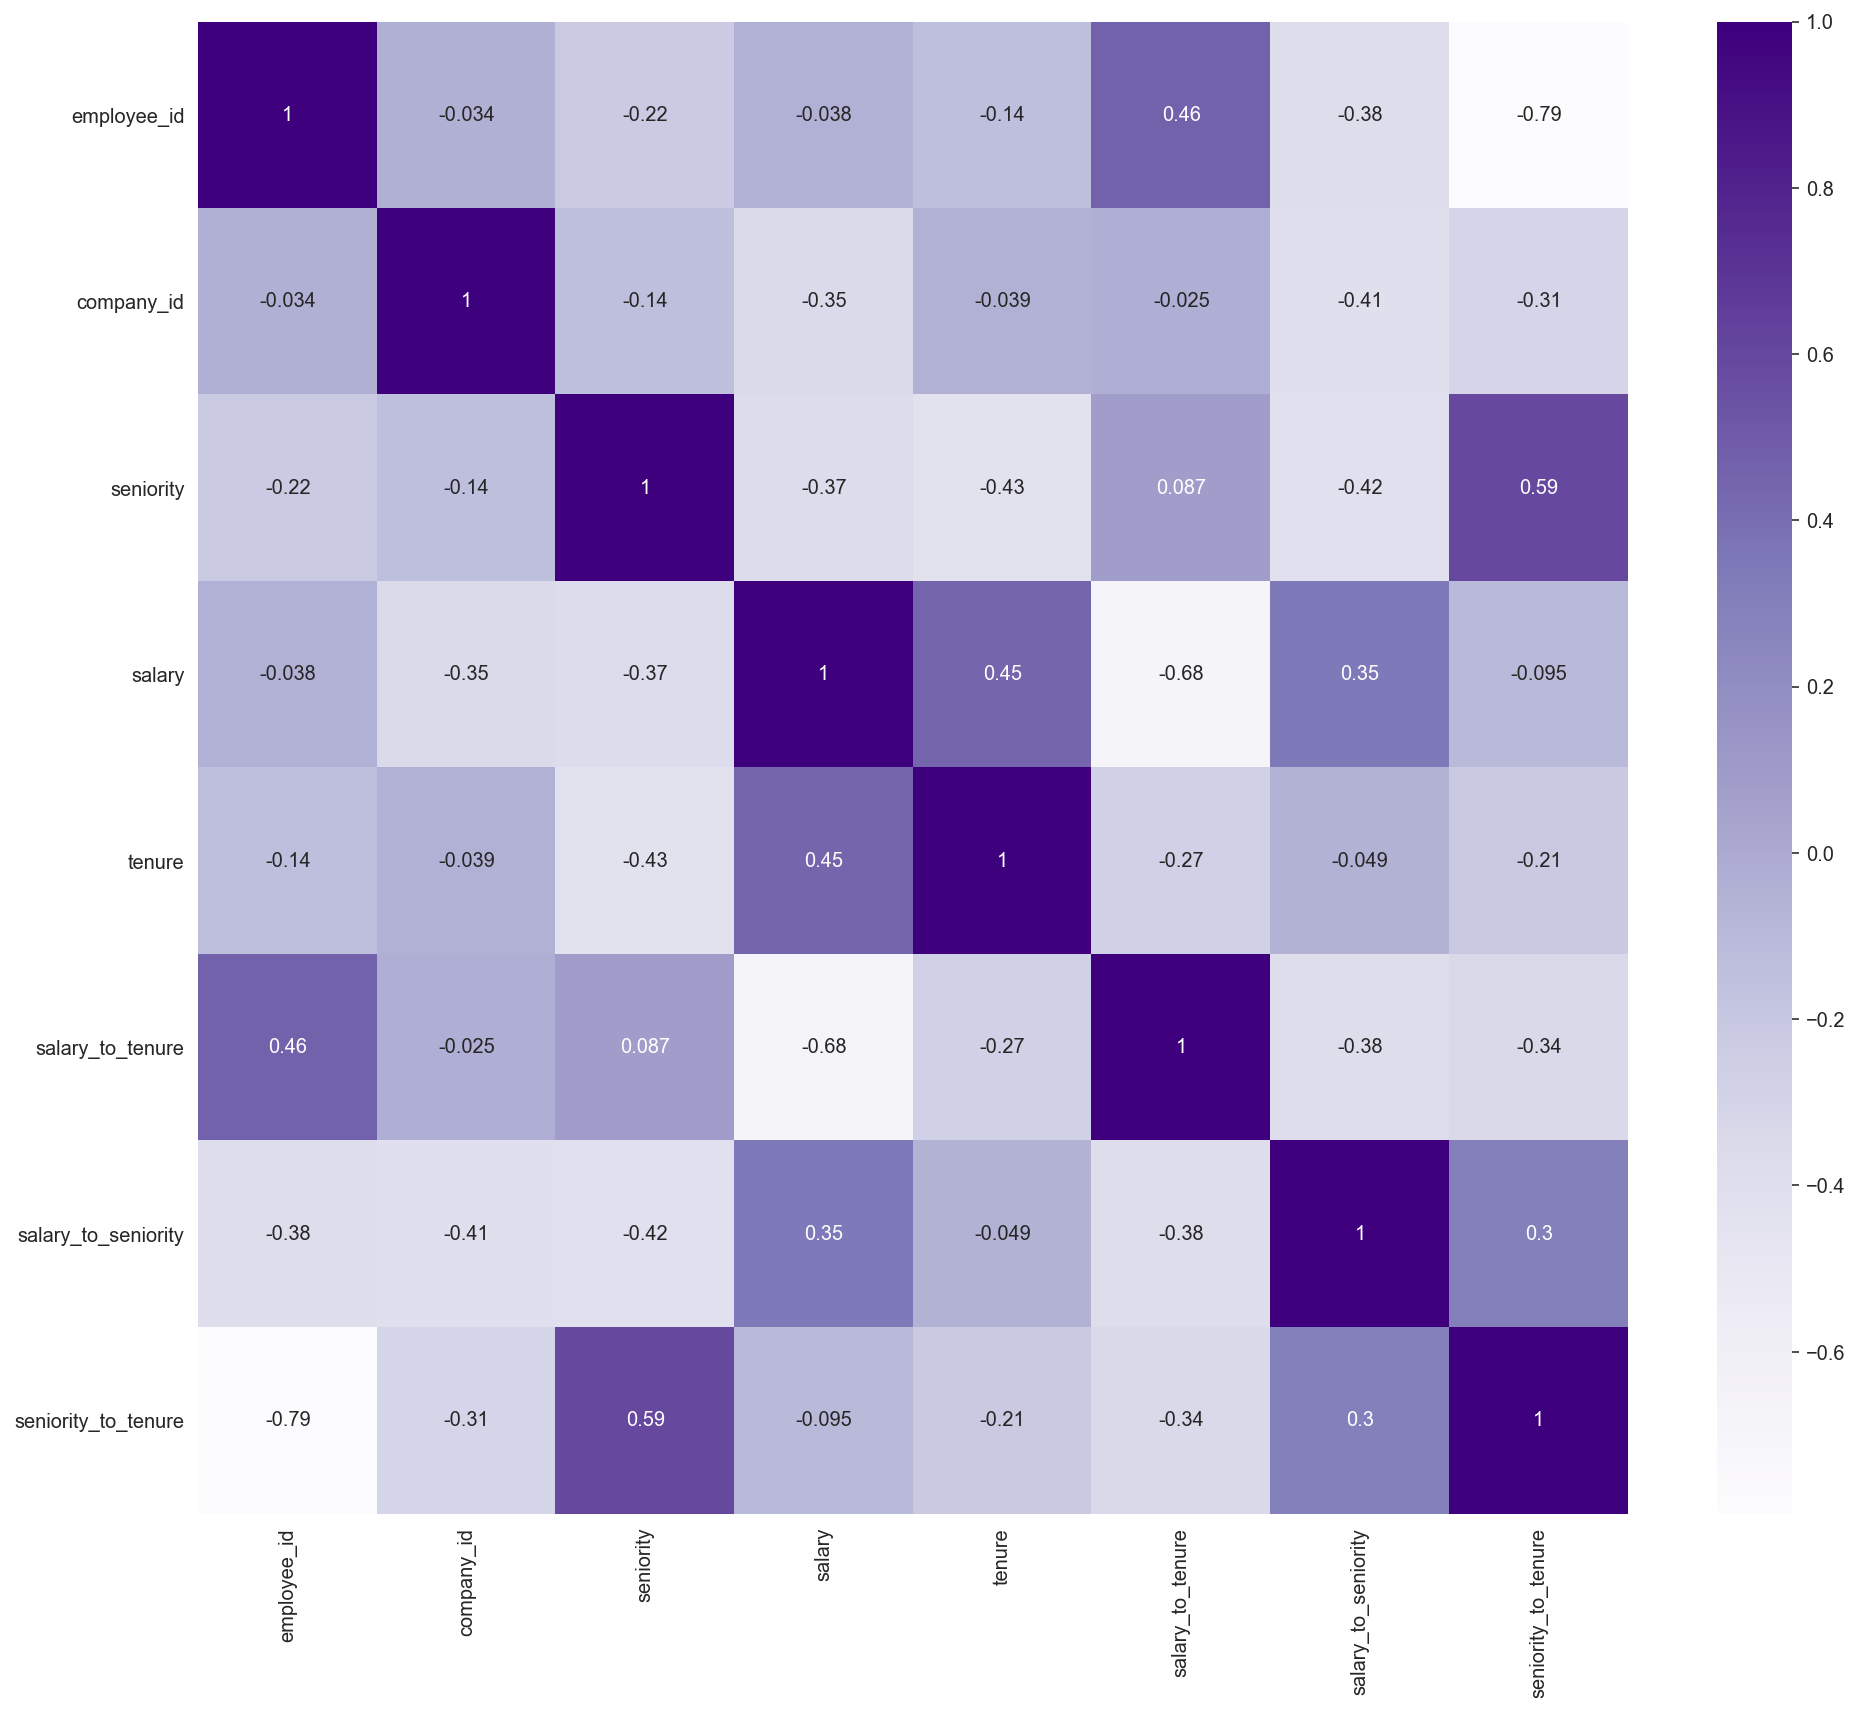

In [37]:
f = plot_corr(sorted_corr, cmap = 'Purples')

- Salary and tenure are strongly correlated
- Salary to seniority and seniority to tenure are highly correlated

## Log Scale the data

In [38]:
cols = ['seniority','salary','tenure']
df_log = df.copy()
for c in cols:
    df_log[c] = np.where (df_log[c] <= 0, 1, df_log[c])
df_log = df_log[cols].fillna(1).apply(np.log, axis = 1).round(3)


In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(df_log)
df_scaled = pd.DataFrame(scaled, index = df_log.index, columns = df_log.columns)

## Employee Segmentation

#### Elbow Method of determining K

In [40]:
def elbow_kmeans (X_train, min_k, max_k):
    """Plots an elbow graph to determine the optimal
    value of k for K-Means clustering. Input is a training set,
    a minimum k value, and a maximum k value. Returns nothing."""
    
    from sklearn.cluster import KMeans
    if len(X_train.columns.values) == 1:
        X = np.array(X_train).reshape(-1, 1)
    else:
        X = np.array(X_train)
    elbow = {}
    for k in np.arange(min_k, max_k):
        model = KMeans (n_clusters = k, max_iter = 1000)
        k_means = model.fit(X)
        elbow[k] = k_means.inertia_

    fig, ax = plt.subplots(1,1, figsize = (8,8))
    ax.plot(list(elbow.keys()), list(elbow.values()), 
            marker = 'o', ms = 10, mec = 'dimgray', lw = 4)
    ax.set_xlabel ('\n K values', fontsize = 20)
    ax.set_ylabel ('Sum of Squares Error\n', fontsize = 20) 
    ax.set_title('\nElbow Method for determining K\n', fontsize = 20)
    ax.tick_params(labelsize = 18)
    plt.show()

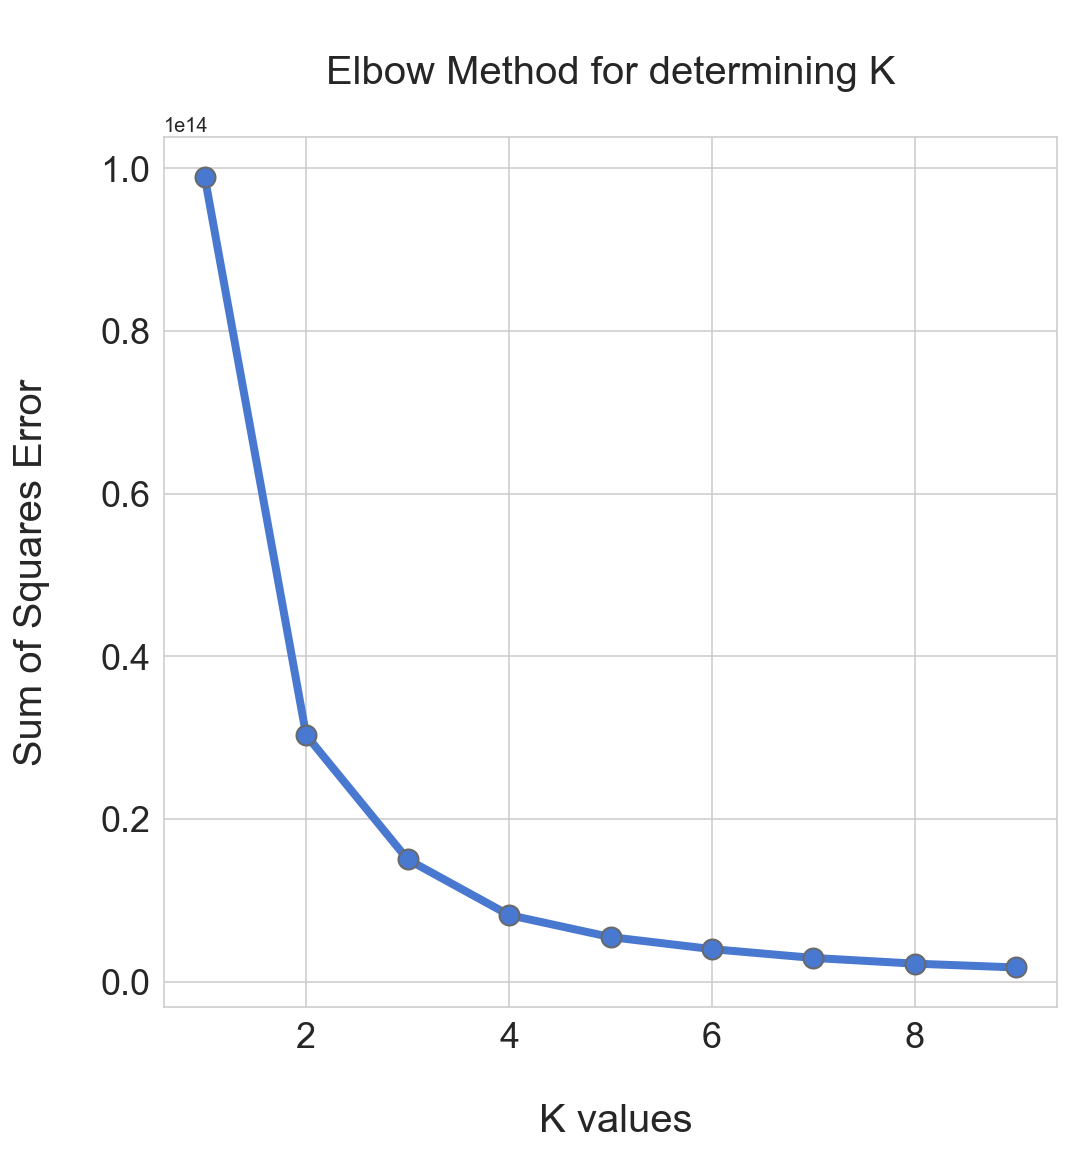

In [41]:
df = df.dropna()
#elbow_kmeans(df_scaled[['seniority', 'salary', 'tenure']], 1, 10)
elbow_kmeans(df[['seniority', 'salary', 'tenure']], 1, 10)

#### K-Means Clustering

In [42]:
def kmeans (X_train, k):
    """Wrapper for sklearn's KMeans clustering alg. Input
    is a training set and number of clusters. Returns cluster 
    assignments for each row in the training set."""
    
    from sklearn.cluster import KMeans
    if len(X_train.columns.values) == 1:
        X = np.array(X_train).reshape(-1, 1)
    else:
        X = np.array(X_train)
    model = KMeans (n_clusters = k, max_iter = 1000)
    k_means = model.fit(X)
    clusters = k_means.predict(X)
    centroids = model.cluster_centers_
    colors = cm.Set2(clusters.astype(float) / k)
    
    fig, ax = plt.subplots (1,1, figsize = (10,10))
    ax.scatter(X[:,0], X[:,1], s = 20, c = colors, alpha = 1) 
    ax.scatter(centroids[:, 0], centroids[:, 1], marker='o', c="white", alpha=1, s=800, edgecolor='gray')
    for i, c in enumerate(centroids):
        ax.annotate(i, xy = (c[0] - c[0] * 0.02, c[1] - c[1] * 0.02),size = 16, weight = 'bold')
    ax.set_xlim(0,40)
    plt.show()
    return clusters

### Add cluster # to original dataframe and visualize

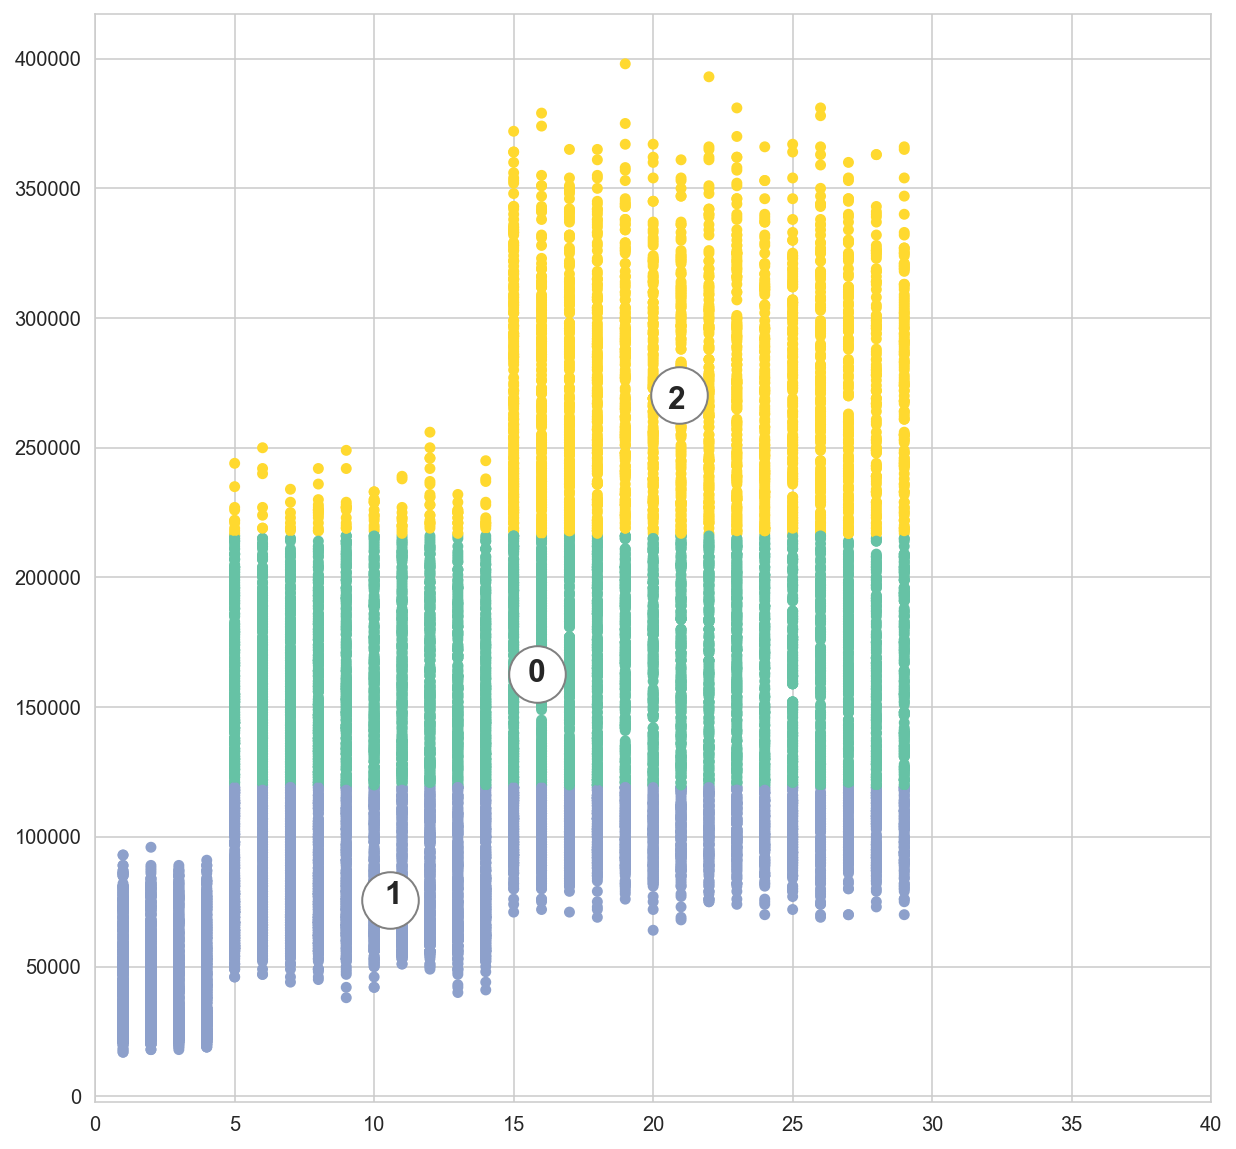

In [43]:
#df_scaled['cluster'] = kmeans(df_scaled[['seniority', 'salary', 'tenure']], 3)
df['cluster'] = kmeans(df[['seniority', 'salary', 'tenure']], 3)


In [44]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,status,tenure,salary_to_tenure,salary_to_seniority,seniority_to_tenure,cluster
2,407990.0,3,design,9,90000.0,2012-03-26,2015-04-10,1,1110,81.081081,10000.000000,0.008108,1
3,120657.0,2,engineer,20,298000.0,2013-04-08,2015-01-30,1,662,450.151057,14900.000000,0.030211,2
5,287530.0,5,marketing,20,180000.0,2014-06-30,2015-12-13,0,531,338.983051,9000.000000,0.037665,0
6,561043.0,3,customer_service,18,119000.0,2012-07-02,2014-03-28,1,634,187.697161,6611.111111,0.028391,1
9,622587.0,5,sales,28,166000.0,2015-07-01,2015-12-13,0,165,1006.060606,5928.571429,0.169697,0


## Agglomerative Heirarchical Clustering

#### Using Scipy 
Can use the linkages to plot the data. Scikit learn doesn't report linkage distance

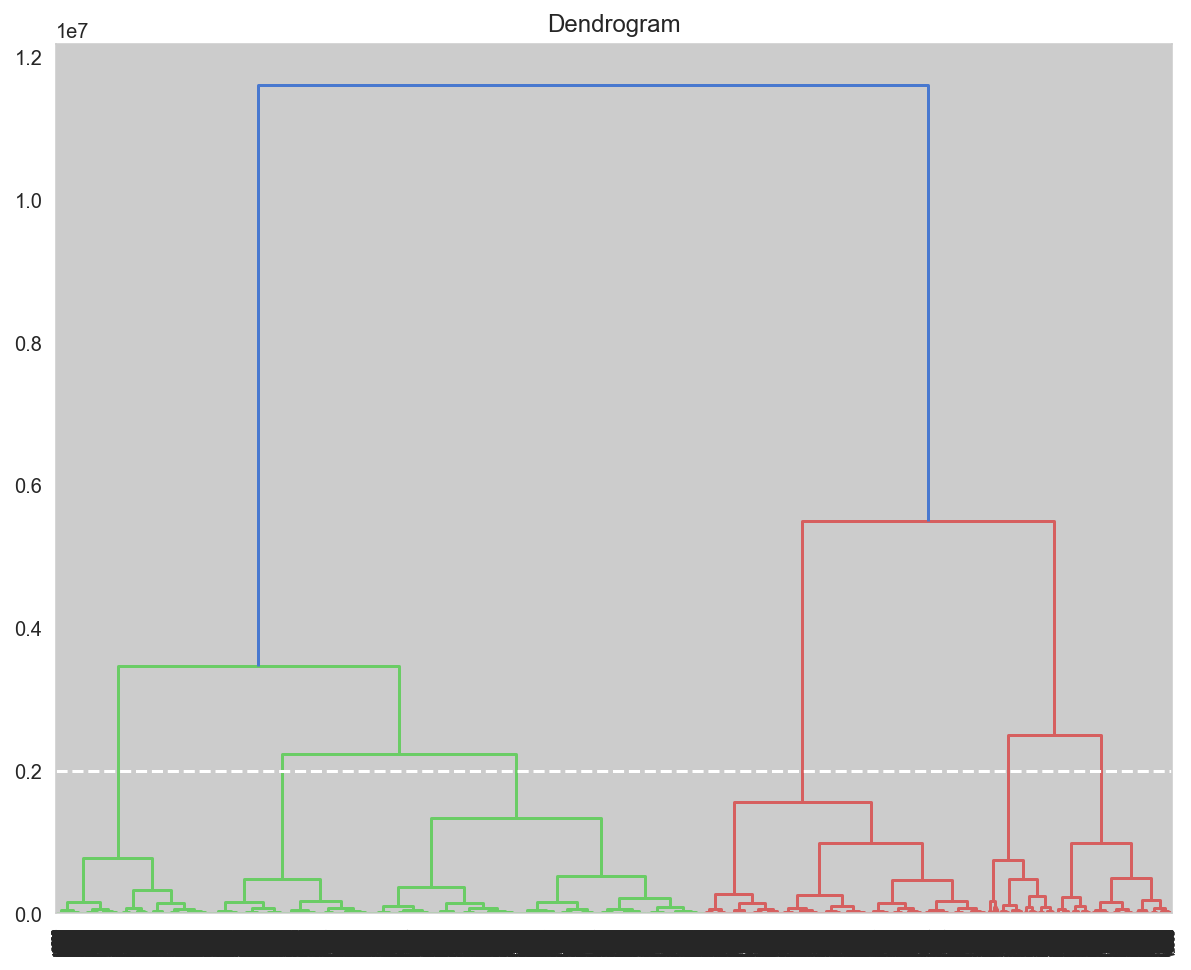

In [45]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize = (10,8))
plt.title ("Dendrogram")
dend = shc.dendrogram(shc.linkage(df[cols], method = 'ward'))
plt.axhline(y=2000000, color='white', linestyle='--')

### Using Scikit-learn
default is ward linkage, so measures euclidian distance like scipy above. Advantage is that you can return a series with the cluster labels and attach it to your data frame. Disadvantage is that linkage distance is hard to interpret. It's best to truncate the dendrogram at the 3rd or 4th split because no one cares past that and it's memory intensive. 

In [46]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(df[cols])
df['hier_cluster'] = clustering.labels_

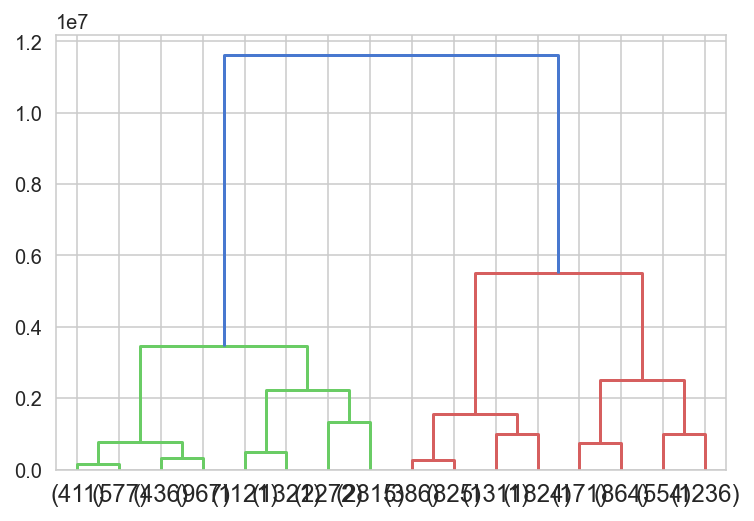

In [47]:
from scipy.cluster.hierarchy import dendrogram
counts = np.zeros(clustering.children_.shape[0])
n_samples = len(clustering.labels_)
for i, merge in enumerate(clustering.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([clustering.children_, clustering.distances_,
                                      counts]).astype(float)
d = dendrogram(linkage_matrix, truncate_mode='level', p=3)
plt.show()

## Feature Ranking (Visualization Only)
This is used by financial analysts but is generally frowned on in data science for being too qualitative. It can be a good visualization tool in certain circumstances like understanding this dataset but I don't recommend ever reporting it as part of a model

In [48]:
score_labels = ['0', '1','2'] 
dfs = pd.DataFrame(df[['status','dept', 'company_id', 'cluster']])
for c in ['seniority', 'salary', 'tenure', 'salary_to_tenure', 'salary_to_seniority', 'seniority_to_tenure']:
    
        dfs[c] = pd.qcut(df[c].dropna(), q = 3, labels = score_labels, duplicates = 'drop').astype(int)
        
dfs.head()

,status,dept,company_id,cluster,seniority,salary,tenure,salary_to_tenure,salary_to_seniority,seniority_to_tenure
2,1,design,3,1,0,0,2,0,1,0
3,1,engineer,2,2,2,2,1,2,2,1
5,0,marketing,5,0,2,2,1,1,1,1
6,1,customer_service,3,1,1,1,1,1,0,1
9,0,sales,5,0,2,2,0,2,0,2


## Cluster Analysis

## What are the differences between Current and Past Users 

In [49]:
dfg = dfs.groupby(['status']).mean()
dfg

,company_id,cluster,seniority,salary,tenure,salary_to_tenure,salary_to_seniority,seniority_to_tenure
status,,,,,,,,
0,3.377402,0.857604,0.978331,1.009029,0.868567,1.117245,1.030311,1.094286
1,3.447848,0.760120,0.990576,0.985650,1.106982,0.902656,0.974620,0.921504


In [50]:
dfg = dfg.reset_index()

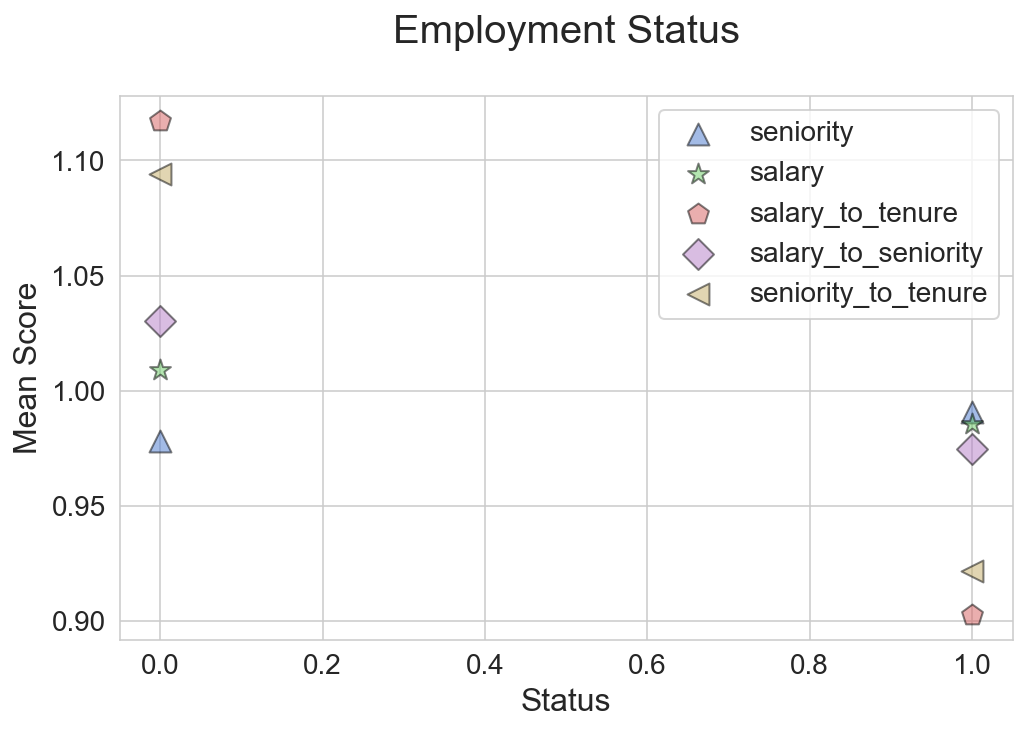

In [51]:
f = visualize_segments (dfg, 'status', ['cluster', 'company_id', 'tenure'])

- **Salary to tenure ratio is lower in currently employed**
- **Seniority to tenure is lower**
- Salary to seniority is lower
- Seniority level is the same
- Salary is roughly the same

## Do all companies have the same issues with turnover?

In [52]:
dfg = dfs.groupby(['company_id']).mean()
dfg = dfg.reset_index()
dfg.head()

,company_id,cluster,seniority,salary,tenure,salary_to_tenure,salary_to_seniority,seniority_to_tenure
0,1,0.782904,0.988636,1.117028,1.019166,1.067503,1.126696,0.988976
1,2,0.805489,0.999657,1.123156,1.006175,1.084734,1.124528,0.997942
2,3,0.800421,0.983676,0.868352,0.987888,0.928383,0.852554,1.005793
3,4,0.827221,0.978843,0.885755,0.991537,0.938646,0.863188,1.023272
4,5,0.826122,1.024490,0.875102,0.991020,0.902041,0.840816,1.017959


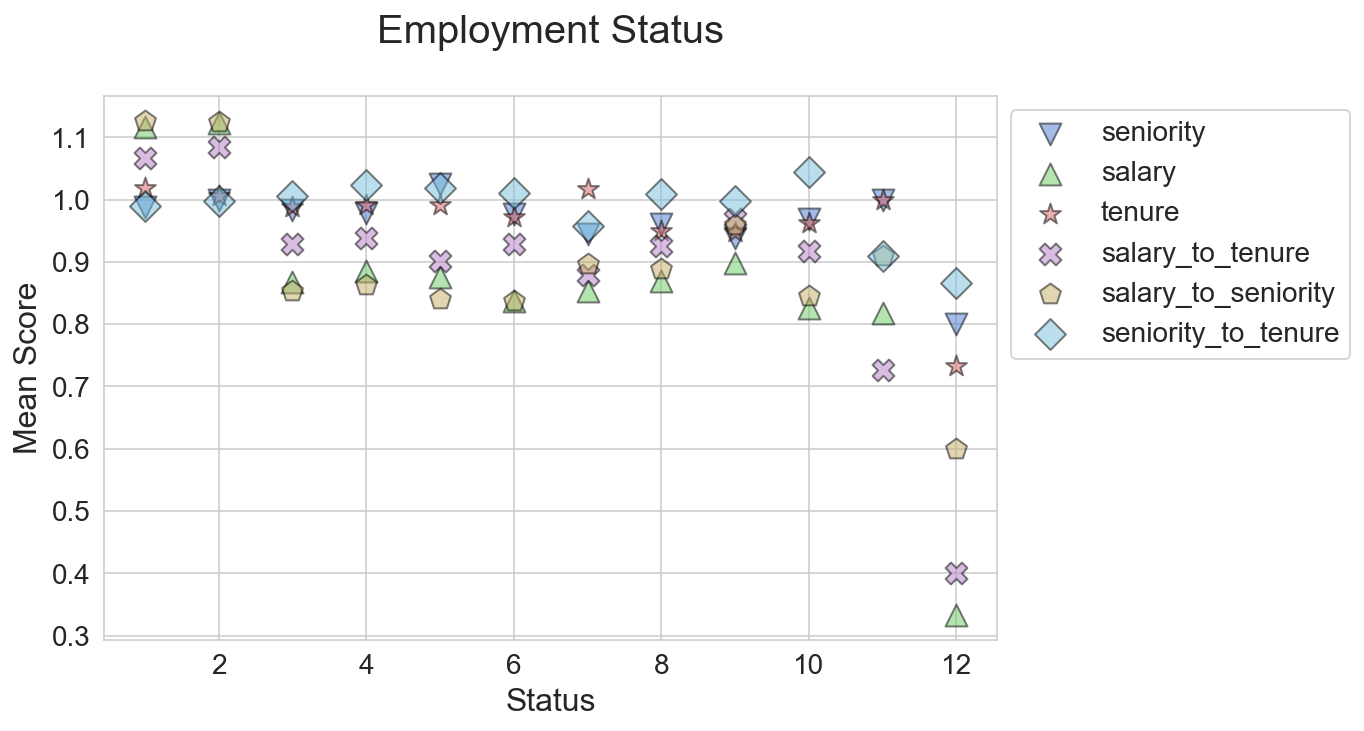

In [53]:
f = visualize_segments (dfg, 'company_id', ['cluster', 'status'])

- Companies 1 and 2 are similar, esp with regard to salary/tenure ratio, have the highest salar/seniority ratio, and are the highest paid
- Companies 3-10 are similar and have lower salary to tenure ratio with lower pay
- Company 11 has the lowest salary to tenure ratio, a low salary, and lower seniority to tenure ratio
- Company 12 is the lowest paid, like really low, has the lowest salary to tenure ratio, and lowest salary to seniority ratio


## Is the Turnover Rate different at each company?

In [54]:
dfg = df.groupby(['company_id', 'status']).mean()
dfg = dfg.reset_index()
dfg.head()

,company_id,status,employee_id,seniority,salary,tenure,salary_to_tenure,salary_to_seniority,seniority_to_tenure,cluster,hier_cluster
0,1,0,508317.479167,14.122024,157660.342262,539.754836,934.760311,14535.568861,0.084414,0.844122,8369.437872
1,1,1,507697.974751,14.108479,147194.825436,617.016209,296.168658,14039.461199,0.028739,0.731608,8714.138092
2,2,0,505246.979016,14.373372,160216.353111,538.136758,1087.031421,14411.720293,0.092117,0.889291,8506.035456
3,2,1,492747.093933,14.095890,149241.356817,626.765166,294.940300,13916.877037,0.028479,0.729941,8550.399217
4,3,0,492204.391765,13.945882,121251.764706,520.096471,841.134728,11396.101704,0.100532,0.821176,8475.156471


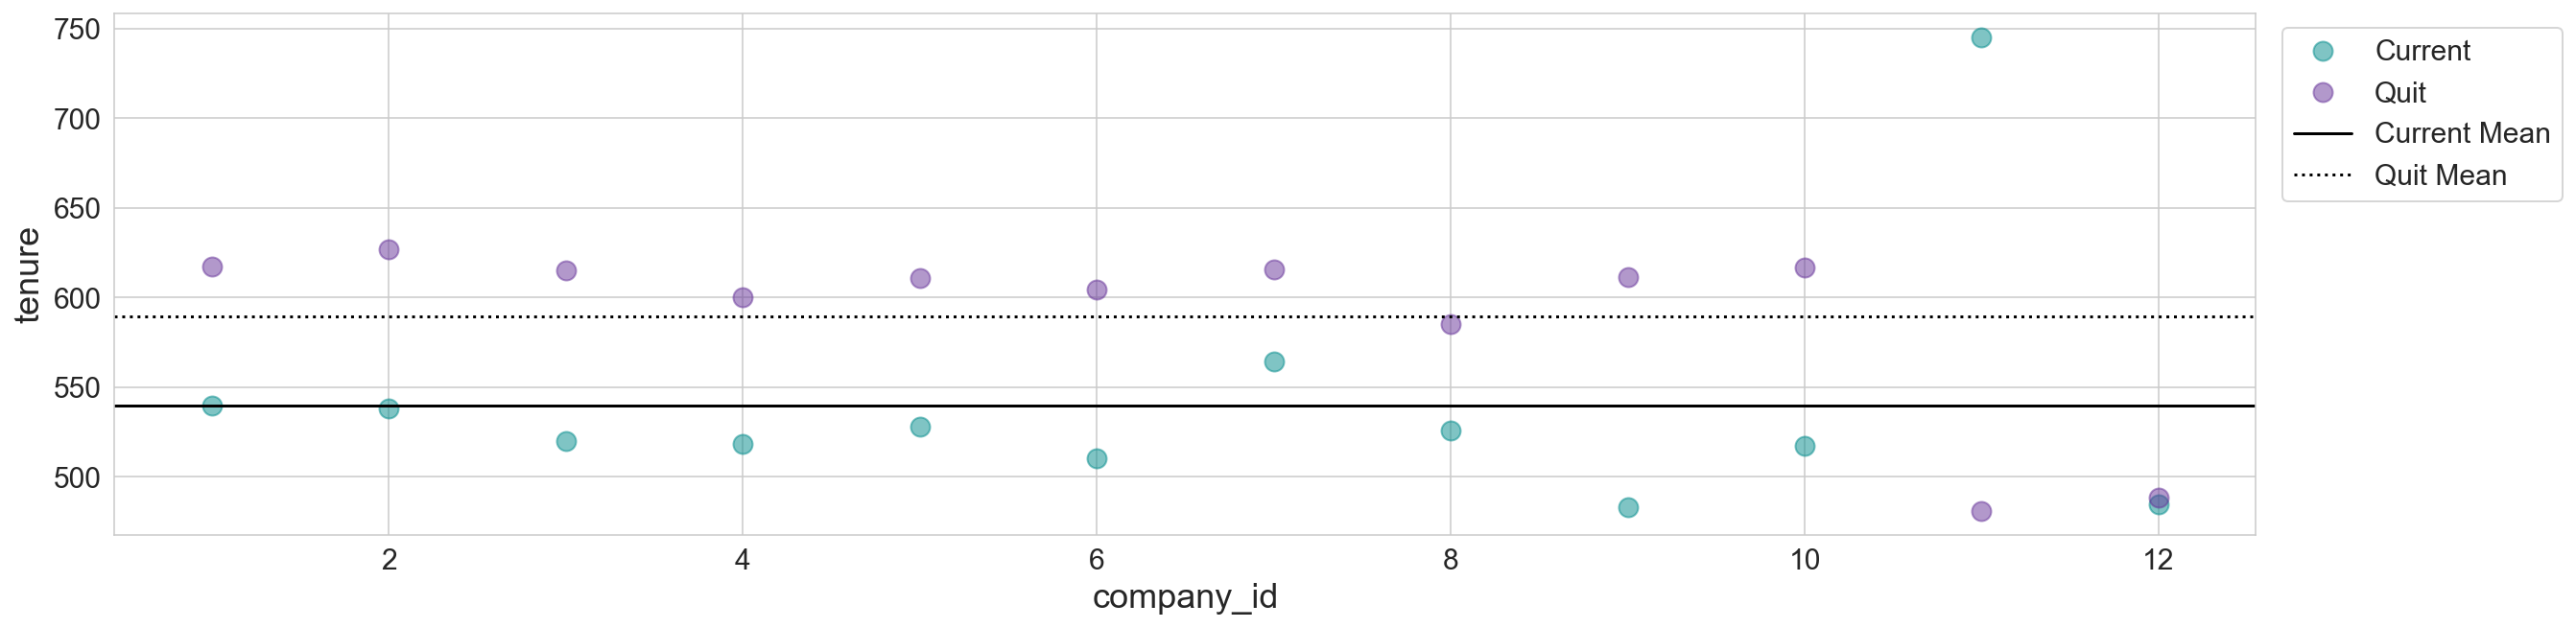

In [55]:
a = group_scatter(dfg, 'company_id', 'tenure')

- Companies 1-10 have current employees that have not reached the average length of tenure of the quitters, so they are likely to be quitting if changes aren't made
- Company 11 has the highest number of long-tenured employees despite low salary
- Company 12 has the lowest tenure, lowest seniority, and lowest pay

## Suggestions